# Distance between veins

One key aspect we would like to determine is what is the distance between central and portal veins. For this we will load a full segmented image and work with the central and portal vein channels.

In [1]:
from pathlib import Path
import napari

from gulliver.io import get_image, get_labels_from_zarr, get_channel_from_zarr
from gulliver.quantify import find_distances
from gulliver.segmenter import relabel_by_values

c:\Users\agucor\Anaconda3\envs\bile_duct_clf\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
DATA_DIR = Path("../data/N1 B9-2 10x.zarr")

In [3]:
image = get_image(DATA_DIR, 0)

zarr image already exists


In [4]:
x_scale = image.attrs["multiscales"][0]["metadata"]["scale"]["x"]

In [5]:
portal_veins = get_labels_from_zarr(image, "portal_veins")
central_veins = get_labels_from_zarr(image, "central_veins")

In [6]:
portal_vein_table = find_distances(
    portal_veins,
    relative_to_mask=central_veins[:] > 0,
    suffix="portal_from_central_",
    scale=x_scale,
)

In [7]:
portal_vein_table

,portal_from_central__distance_max,portal_from_central__distance_min,portal_from_central__distance_mean,label
0,129.134242,4.550000,71.702363,11
1,159.365366,145.363312,152.564150,13
2,174.370905,162.063915,167.746528,14
3,152.783188,131.898759,141.678339,15
4,87.882308,64.346717,76.393549,18
...,...,...,...,...
206,54.445018,30.466908,43.592839,629
207,48.953243,36.975803,43.269027,631
208,62.619665,52.581746,57.742456,632
209,65.585612,59.817660,62.718940,637


In [8]:
central_vein_table = find_distances(
    central_veins, portal_veins[:] > 1, suffix="central_from_portal"
)

In [9]:
distance_labeled_portals = relabel_by_values(
    portal_veins,
    labels=portal_vein_table.label.values,
    values=portal_vein_table.portal_from_central__distance_min.values,
)

13-Mar-24 15:42:09 - bfio.backends - WARNING  - Java backend is not available. This could be due to a missing dependency (jpype).


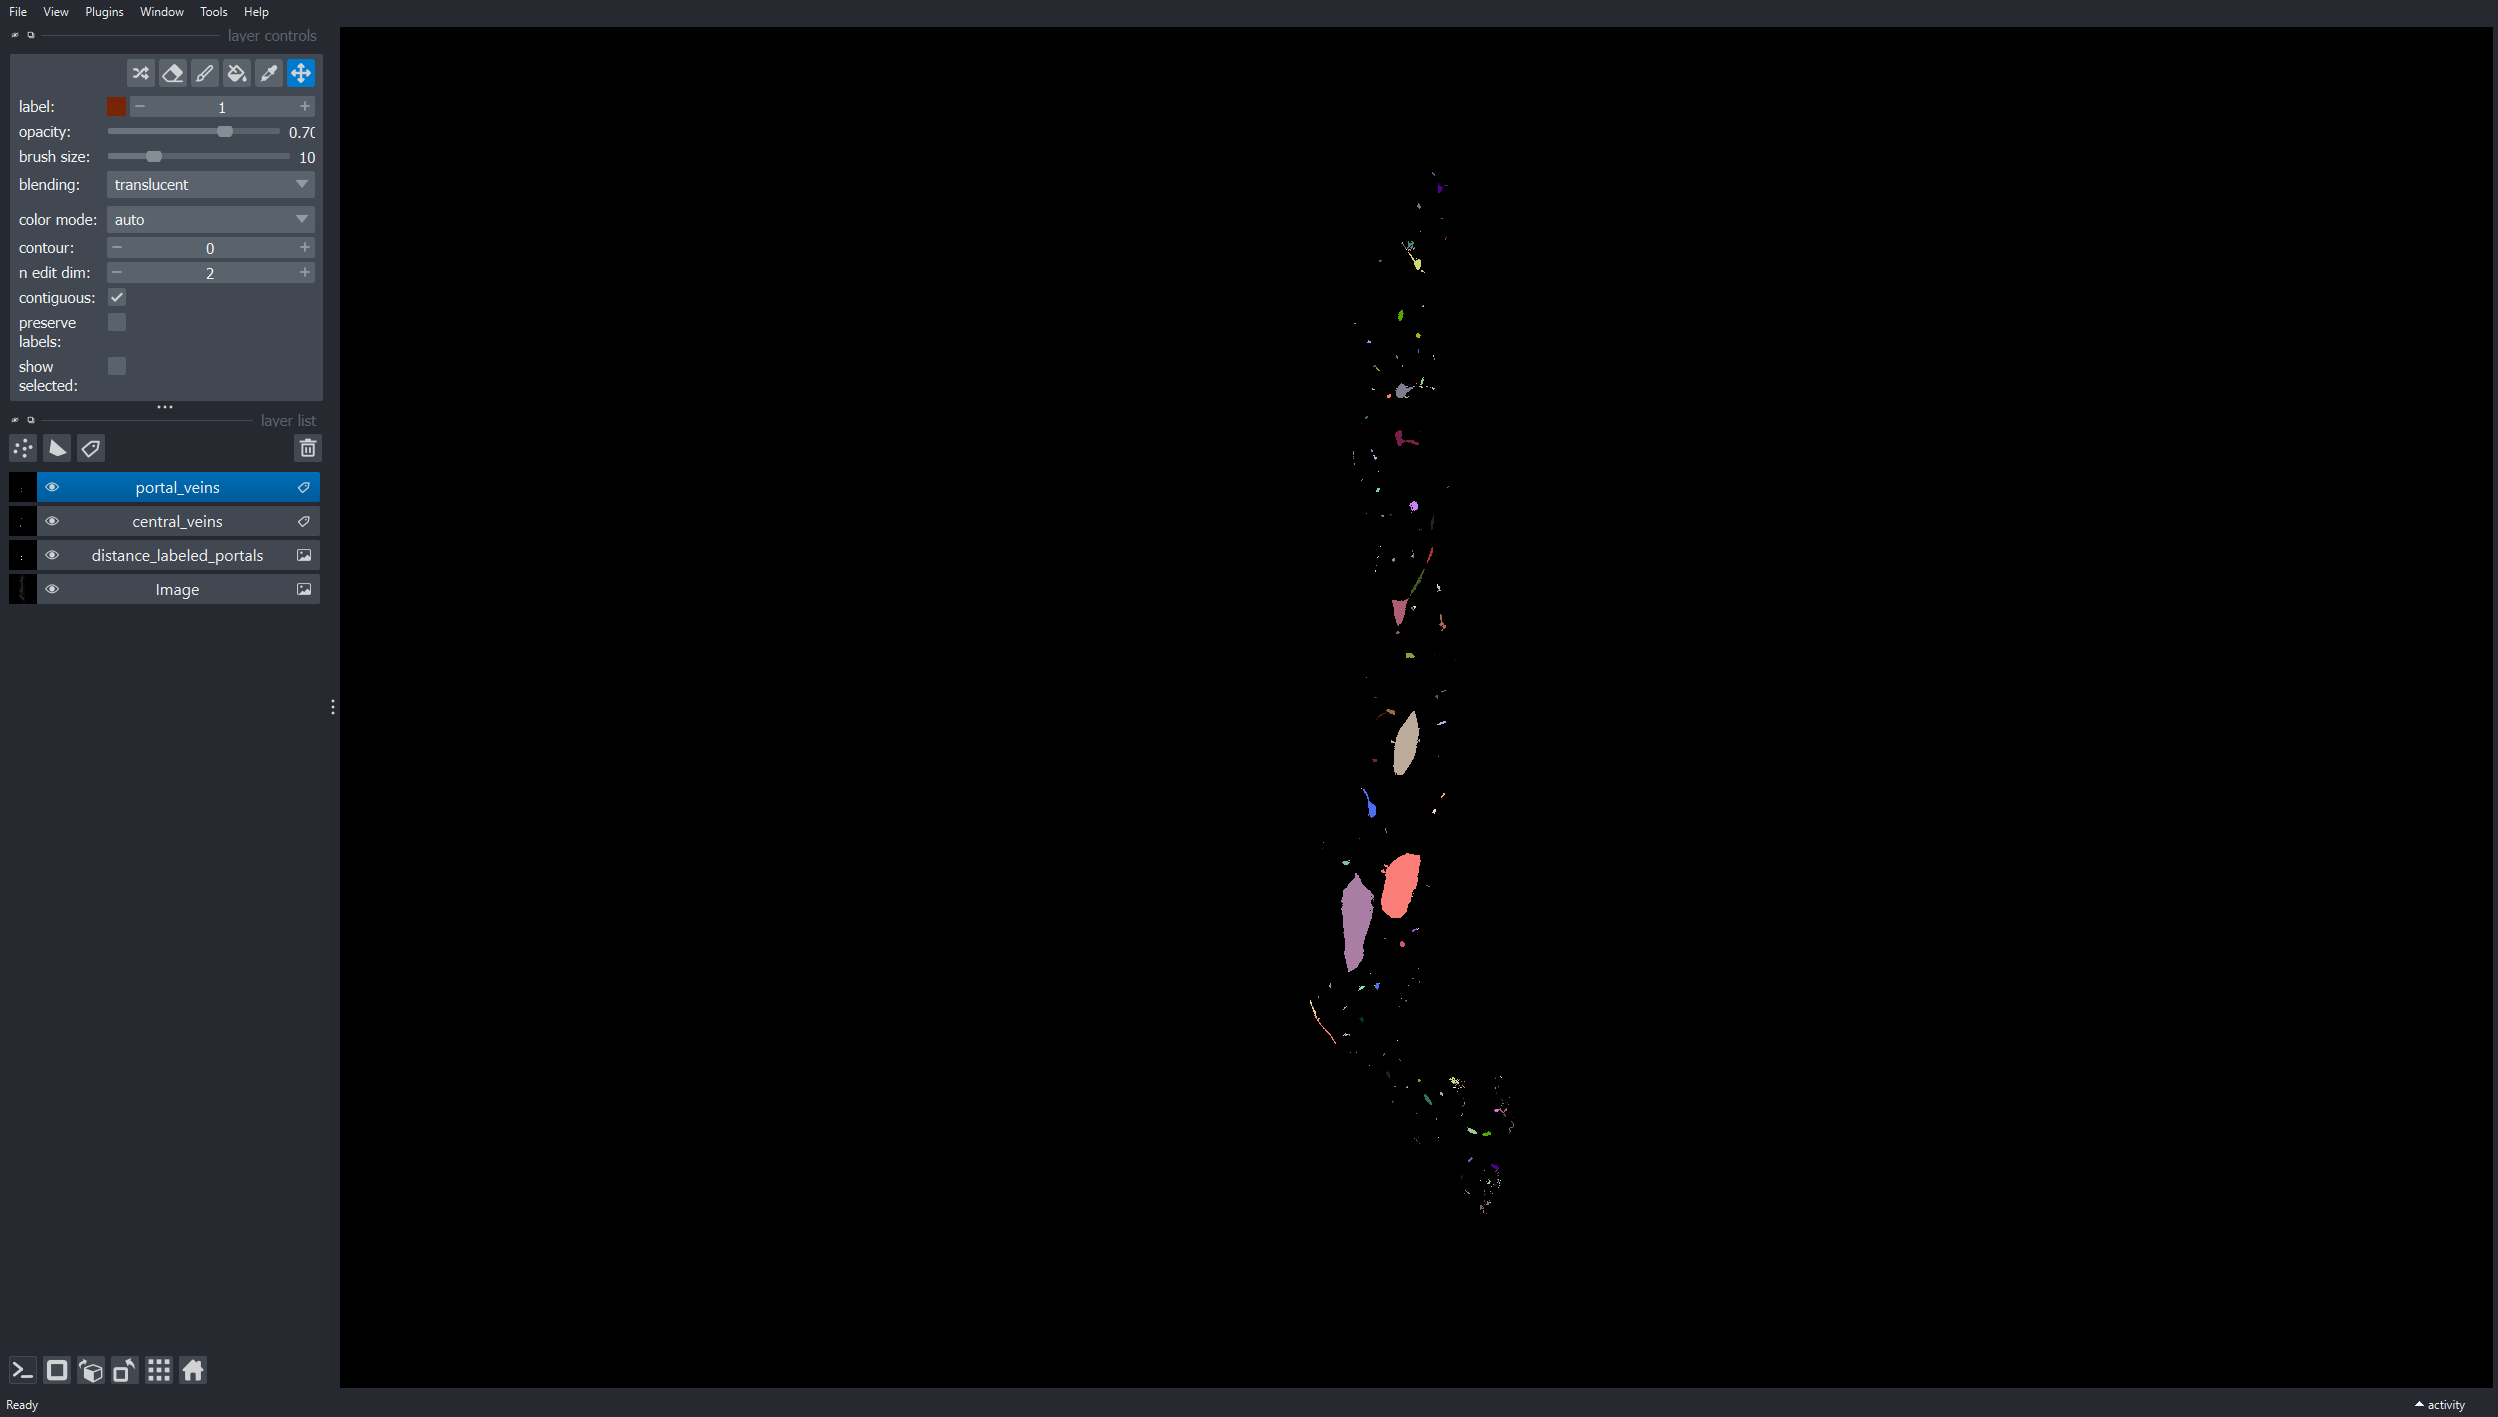

In [10]:
viewer = napari.Viewer()
viewer.add_image(
    get_channel_from_zarr(image, "Sox9"), contrast_limits=(0, 2**16)
)
viewer.add_image(distance_labeled_portals)
viewer.add_labels(central_veins)
viewer.add_labels(portal_veins)
napari.utils.nbscreenshot(viewer)

With these we can make tables saving the distances between veins and save them into excel files.

# Single Function

We can assess that the single funciton to describe veins is working.

In [11]:
from gulliver.quantify import get_vein_properties

In [12]:
portal_table = get_vein_properties(
    vein=portal_veins, other_vein=central_veins[:] > 0, scale=x_scale
)

In [13]:
portal_table

,area,eccentricity,distance_max,distance_min,distance_mean
label,,,,,
11,5105.4900,0.761826,129.134242,4.550000,71.702363
13,183.3650,0.717163,159.365366,145.363312,152.564150
14,159.2825,0.797100,174.370905,162.063915,167.746528
15,735.5725,0.981217,152.783188,131.898759,141.678339
18,184.2100,0.932914,87.882308,64.346717,76.393549
...,...,...,...,...,...
629,215.4750,0.942487,54.445018,30.466908,43.592839
631,115.7650,0.651380,48.953243,36.975803,43.269027
632,73.0925,0.572524,62.619665,52.581746,57.742456
